# Metadata

```
Course:   DS 5001
Module:   13 Lab
Topic:    Classification with a suite of SKLearn' linear classifiers
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'winereviews'

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px
import importlib
from sklearn.metrics import RocCurveDisplay

# Get Data

In [5]:
DOCS = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_DOCS.csv").set_index(['doc_id'])
X_TRAIN = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TRAIN.csv").set_index(['doc_id'])
X_TEST = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TEST.csv").set_index(['doc_id'])
VOCAB = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_VOCAB.csv").set_index(['term_str'])

In [6]:
y_TRAIN = X_TRAIN.join(DOCS.doc_label).doc_label
y_TEST = X_TEST.join(DOCS.doc_label).doc_label

# Fit Models

In [7]:
models = {
    'LogisticRegression': {
        'slug': 'LR',
        'package': 'sklearn.linear_model',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    },
    'Perceptron': {
        'slug': 'PT',
        'package': 'sklearn.linear_model',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    },
    'BernoulliNB': {
        'slug': 'NB',
        'package': 'sklearn.naive_bayes',
        'args': {},
        'weights_cfg': {
            'data': 'feature_log_prob_',
            'cols': 'feature_names_in_',
            'idx': 'classes_',
            'transpose': True
        }
    },
    'LinearSVC': {
        'slug': 'SV',
        'package': 'sklearn.svm',
        'args': {},
        'weights_cfg': {
            'data': 'coef_',
            'cols': 'feature_names_in_',
            'idx': None,
            'transpose': True
        }
    }
}

In [30]:
def score_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    # print(R)
    # print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # FPR: Falsse Positive Rate, 1 - Specificity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    
    TPR = R.TP / (R.TP + R.FN) # Correct   guesses of P over all actual  P
    FPR = R.FP / (R.FP + R.TN) # Incorrect guesses of P over all actual  N  = 1 - Specificity
    TNR = R.TN / (R.TN + R.FP) # Correct   guesses of N over all actual  N
                               # Incorrect guesses of N over all actual  P ?
        
    PPV = R.TP / (R.TP + R.FP) # Correct   guesses of P over all guessed P
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()
    
    return {
        'TP' : R.TP,
        'TN' : R.TN,
        'FP' : R.FP,
        'FN' : R.FN,
        'TPR': round(TPR, 2),
        'TNR': round(TNR, 2),
        'F1' : round(F1,  2),
        'PPV': round(PPV, 2),
        'ACC': round(ACC, 2)
    }



In [31]:
def run_model(model_name):
    global models, X_TRAIN, X_TEST, y_TRAIN, y_TEST
    
    M = models[model_name]
    slug = M['slug']
    
    model_class = getattr(
        importlib.import_module(M['package']), 
        model_name
    )
    
    clf = model_class(**M['args'])
    clf.fit(X_TRAIN, y_TRAIN)
        
    M['score'] = clf.score(X_TRAIN, y_TRAIN)
    M['predictions'] = clf.predict(X_TEST)
    y_PREDICT = pd.Series(M['predictions'], index=X_TEST.index)
    
    RESULTS = pd.concat([y_TEST, y_PREDICT], axis=1, keys=['actual','prediction'])
    RESULTS['result'] = RESULTS.actual == RESULTS.prediction
    RESULTS['result_type'] = RESULTS.result.astype('str').str[0] + RESULTS.prediction
    M['results'] = RESULTS
    
    M['scores'] = score_results(RESULTS)
    
    M['_object'] = clf
    
    df_data = getattr(clf, M['weights_cfg']['data'])
    # M['df_data'] = df_data
    
    if M['weights_cfg']['idx']:
        df_idx = getattr(clf, M['weights_cfg']['idx'])
    else:
        df_idx = [f'{slug}_weight']
        
    if M['weights_cfg']['cols']:
        df_cols = getattr(clf, M['weights_cfg']['cols'])
    else:
        df_cols = None

    try:
        M['weights'] = pd.DataFrame(df_data, index=df_idx, columns=df_cols)
        if M['weights_cfg']['transpose']:
            M['weights'] = M['weights'].T
        M['weights'].index.name = 'term_str'
    except ValueError as e:
        print(e)
        M['weights'] = None
    

In [32]:
for model_name in list(models.keys()):    
    print(model_name)
    run_model(model_name)

LogisticRegression
Perceptron
BernoulliNB
LinearSVC


# Group Weights

In [80]:
WEIGHTS = pd.concat([models[key]['weights'] for key in models.keys()], axis=1)

<AxesSubplot:ylabel='Frequency'>

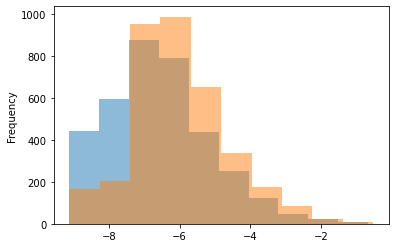

In [56]:
WEIGHTS.N.plot.hist(alpha=.5)
WEIGHTS.P.plot.hist(alpha=.5)

In [85]:
WEIGHTS['NB_weight'] = WEIGHTS.P - WEIGHTS.N
WEIGHTS = WEIGHTS.drop(['N','P'], axis=1)
WEIGHTS_NORMED = (WEIGHTS - WEIGHTS.mean()) / WEIGHTS.std()
WEIGHTS_MEAN = WEIGHTS_NORMED.mean(1).to_frame('weight')

In [86]:
WEIGHTS.sort_values('NB_weight')

,LR_weight,PT_weight,SV_weight,NB_weight
term_str,,,,
everyday,-0.930494,-8.0,-0.485418,-4.948955
easygoing,-1.122648,-12.0,-0.740928,-4.763812
informal,-0.484613,-8.0,-0.502430,-4.269794
dilute,-0.445590,-6.0,-0.213023,-4.167515
watery,-0.494316,-6.0,-0.317010,-4.167515
...,...,...,...,...
decade,1.471041,15.0,0.745516,5.017507
2022,3.148286,33.0,2.028283,5.072627
2023,2.230209,24.0,1.436606,5.269562


In [67]:
WEIGHTS_MEAN

,weight
term_str,
000,-0.647120
04,-0.251263
05,-0.041566
06,-0.354581
07,0.470686
...,...
zinfandel,-0.832831
zing,-0.181530
zingy,-0.629313


# Compare Weights

In [68]:
WEIGHTS_NORMED = (WEIGHTS - WEIGHTS.mean()) / WEIGHTS.std()

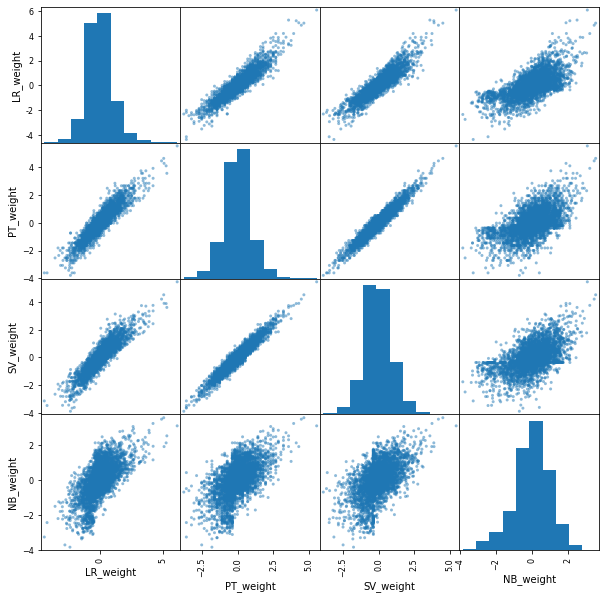

In [69]:
pd.plotting.scatter_matrix(WEIGHTS_NORMED, figsize=(10,10));

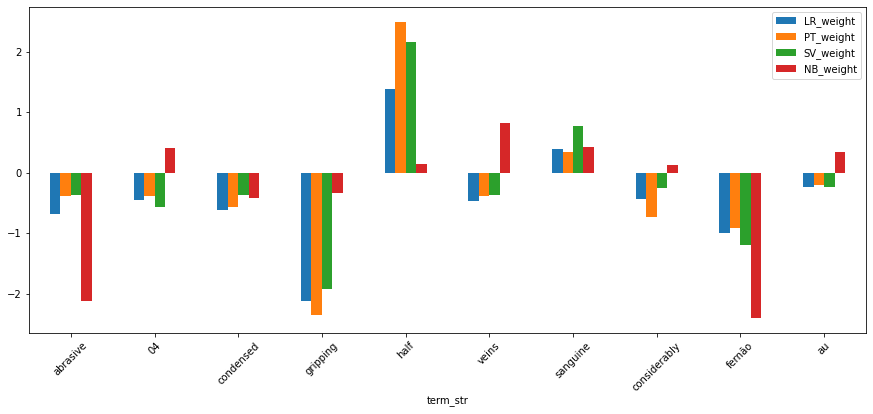

In [70]:
WEIGHTS_NORMED.sample(10).plot.bar(figsize=(15,6), rot=45);

# Get Top and Bottom Terms

In [71]:
tops = {}
bots = {}
for model_name in models.keys():
    slug = models[model_name]['slug']
    col = f"{slug}_weight"
    tops[slug] = WEIGHTS_NORMED.reset_index().sort_values(col, ascending=False).head(20).term_str.reset_index(drop=True)
    bots[slug] = WEIGHTS_NORMED.reset_index().sort_values(col, ascending=True).head(20).term_str.reset_index(drop=True)

tops['mean'] = WEIGHTS_MEAN.reset_index().sort_values('weight', ascending=False).head(20).term_str.reset_index(drop=True)
bots['mean'] = WEIGHTS_MEAN.reset_index().sort_values('weight', ascending=True).head(20).term_str.reset_index(drop=True)

TOPS = pd.concat(tops.values(), keys=tops.keys(), axis=1)
TOPS.index.name = 'rank'
BOTS = pd.concat(bots.values(), keys=tops.keys(), axis=1)
BOTS.index.name = 'rank'

In [72]:
TOPS

,LR,PT,NB,SV,mean
rank,,,,,
0,2022,2022,2025,2022,2022
1,2020,2025,2030,2025,2025
2,beautiful,2030,2023,2030,2030
3,opulent,opulent,2022,opulent,beautiful
4,2025,beautiful,decade,beautiful,opulent
5,2030,2023,2021,2023,2023
6,beautifully,salt,94,brunello,2020
7,delicious,exceptional,2026,exceptional,gorgeous
8,2023,2020,2027,2020,94


In [73]:
BOTS

,LR,PT,NB,SV,mean
rank,,,,,
0,simple,consumed,everyday,consumed,simple
1,lacks,coombsville,easygoing,characters,lacks
2,dishes,characters,informal,coombsville,puckering
3,easy,simple,dilute,lacks,easygoing
4,medium,lacks,watery,puckering,dimensional
5,pleasant,island,simple,island,basic
6,tad,basic,bland,fast,consumed
7,rustic,dimensional,unripe,dimensional,grigio
8,astringent,juiciness,pickled,simple,effervescence


# Compare 

In [74]:
vals = []
idx = []
for model_name in models.keys():
    keys = models[model_name]['scores'].keys()
    idx.append(models[model_name]['slug']) 
    vals.append(models[model_name]['scores'].values())

In [75]:
pd.DataFrame(vals, columns=keys, index=idx).style.background_gradient(cmap='GnBu')

,TP,TN,FP,FN,TPR,TNR,F1,PPV,ACC
LR,2929,2892,95,121,0.960000,0.970000,0.960000,0.970000,0.960000
PT,2895,2871,116,155,0.950000,0.960000,0.960000,0.960000,0.960000
NB,2948,2815,172,102,0.970000,0.940000,0.960000,0.940000,0.950000
SV,2888,2867,120,162,0.950000,0.960000,0.950000,0.960000,0.950000


In [76]:
WEIGHTS

,LR_weight,PT_weight,SV_weight,NB_weight
term_str,,,,
000,-0.214175,-1.0,-0.063846,-0.265062
04,-0.009556,0.0,-0.071005,1.185527
05,0.045278,1.0,0.000000,1.680849
06,-0.004655,0.0,-0.043932,0.458857
07,0.384632,5.0,0.377488,1.018473
...,...,...,...,...
zinfandel,-0.200909,-3.0,-0.083152,-0.781585
zing,0.064768,1.0,-0.017180,0.882341
zingy,-0.089120,-1.0,-0.136584,-0.234290


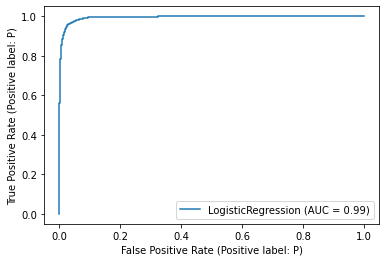

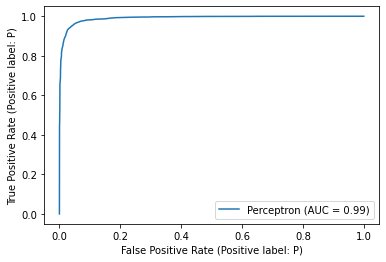

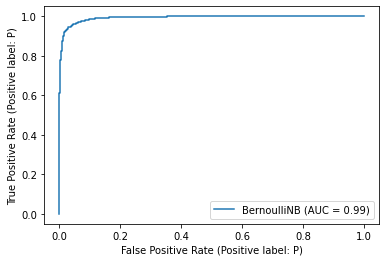

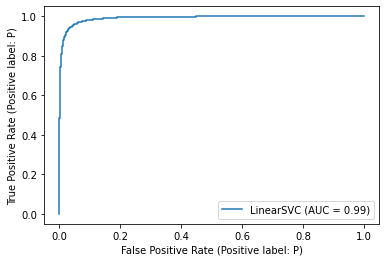

In [77]:
for model_name in models.keys():
    RocCurveDisplay.from_estimator(models[model_name]['_object'], X_TEST, y_TEST)